### INTRO

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

#1a)
# Load dataset
dataset = pd.read_csv('./SpotifyFeatures.csv')

# See https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.shape.html
# pandas.DataFrame.shape: "Return a tuple representing the dimensionality of the DataFrame."
# And in this case (rows, columns)
number_of_samples, number_of_features = dataset.shape

print("Number of samples: ", number_of_samples)
print("Number of features: ", number_of_features)


Number of samples:  232725
Number of features:  18


In [2]:
#1b)
# Make a new DataFrame with samples where genre in matching either Pop or Classical
# https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.loc.html
dataset_only_pop_and_classical = dataset.loc[(dataset['genre'] == 'Pop') | (dataset['genre'] == 'Classical')]

# Add new feature 'label' and set it to 1 if genre is Pop and 0 if genre is Classical
# https://numpy.org/doc/stable/reference/generated/numpy.where.html
dataset_only_pop_and_classical['label'] = np.where(dataset_only_pop_and_classical['genre'] == 'Pop', 1, 0)

# New DataFrame with only the features we want
dataset_with_picked_features = dataset_only_pop_and_classical[['label', 'liveness', 'loudness']]

# Count the number of samples
# https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.Series.value_counts.html
number_of_pop_songs = dataset_with_picked_features['label'].value_counts()[1]
number_of_classical_songs = dataset_with_picked_features['label'].value_counts()[0]

print("Number of pop songs: ", number_of_pop_songs)
print("Number of classical songs: ", number_of_classical_songs)


Number of pop songs:  9386
Number of classical songs:  9256


/var/folders/xc/bb9b3wdd27n8_02btpd2yfj00000gp/T/ipykernel_89454/2555608377.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset_only_pop_and_classical['label'] = np.where(dataset_only_pop_and_classical['genre'] == 'Pop', 1, 0)


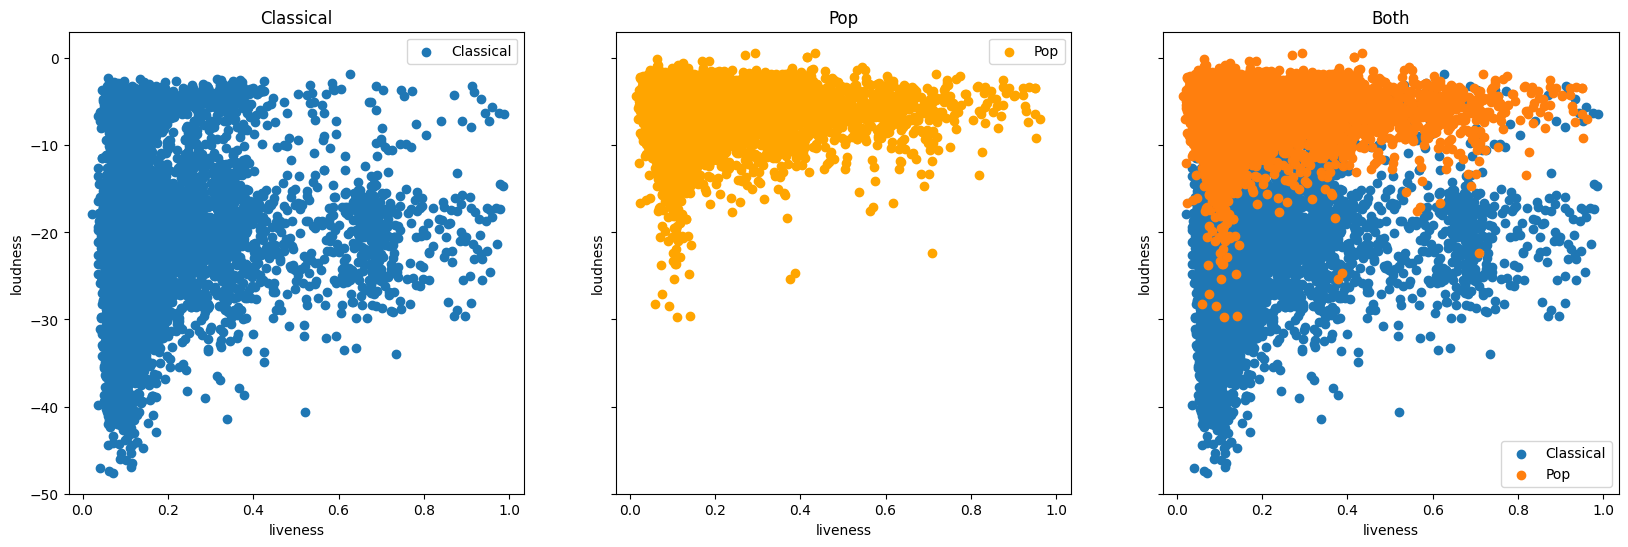

In [3]:
#1c)
# Make two numpy arrays. One containing the wanted features,
# the other containing the labels.
X = dataset_with_picked_features[['liveness', 'loudness']].to_numpy()
y = dataset_with_picked_features['label'].to_numpy()

# Split the test set. Use stratify=y (We set y to be the labels right above).
# This ensures that we get an even split. 80train-20test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=9)

#1d)
# Group data for plotting.
groups = dataset_with_picked_features.groupby('label')
classical_group = groups.get_group(0)
pop_group = groups.get_group(1)

# Create figure with 3 subplots. Set sharex and sharey so that the subplots use the same axes.
fig, axs = plt.subplots(1, 3, figsize=(20, 6), sharex=True, sharey=True)

# Add plot for Classical
axs[0].scatter(classical_group['liveness'], classical_group['loudness'], label='Classical')
axs[0].set_xlabel('liveness')
axs[0].set_ylabel('loudness')
axs[0].set_title('Classical')
axs[0].legend()

# Add plot for Pop
axs[1].scatter(pop_group['liveness'], pop_group['loudness'], c='orange', label='Pop')
axs[1].set_xlabel('liveness')
axs[1].set_ylabel('loudness')
axs[1].set_title('Pop')
axs[1].legend()

# Add plot for both groups
for name, group in groups:
    label_to_genre = 'Pop' if name == 1 else 'Classical'
    axs[2].scatter(group['liveness'], group['loudness'], label=label_to_genre)
    axs[2].set_xlabel('liveness')
    axs[2].set_ylabel('loudness')
    axs[2].set_title('Both')
    axs[2].legend()

plt.show()


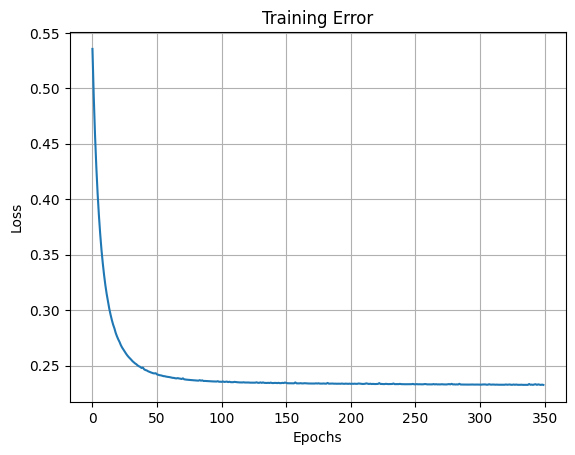

Accuracy for the training set:  0.9277140749681486


In [4]:
#2a)

# Takes any real value as input and outputs values in the range for 0 to 1.
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

# The function is based on the Linear_logistic_regression.pdf. See slides 29 - 31
def binary_cross_entropy_loss(y, y_hat):
    m = len(y)
    return -1/m * np.sum(y * np.log(y_hat) + (1 - y) * np.log(1 - y_hat))

# Derived from the loss function.
def compute_gradients(xi, yi, y_hat):
    return (y_hat - yi) * xi, (y_hat - yi)

def predict(X, weights, bias):
    prediction = sigmoid(np.dot(X, weights) + bias)
    return [1 if i > 0.5 else 0 for i in prediction]

"""
The function logistic_regression is written with help from the pseudo-code from
slide 36 in Linear_logistic_regression.pdf,
https://www.cs.huji.ac.il/~shais/UnderstandingMachineLearning/understanding-machine-learning-theory-algorithms.pdf,
and also help from ChatGPT
for better understanding.
"""
def logistic_regression(X, labels, learning_rate, number_of_epochs):
    losses = []

    # Set up initial values
    number_of_samples, number_of_features = X.shape
    weights = np.zeros(number_of_features)
    bias = 0

    for _ in range(number_of_epochs):
        # May help the learning process if the data is shuffled
        indices = np.arange(number_of_samples)
        np.random.shuffle(indices)

        for indice in indices:
            features = X[indice]
            y = labels[indice]
            y_hat = sigmoid(np.dot(features, weights) + bias)

            # Calculate gradients and update weights and bias
            gradientW, gradientB = compute_gradients(features, y, y_hat)
            weights -= learning_rate * gradientW
            bias -= learning_rate * gradientB

        # Calculate loss
        y_hat = sigmoid(np.dot(X, weights) + bias)
        loss = binary_cross_entropy_loss(labels, y_hat)
        losses.append(loss)

    return weights, bias, losses

# Train the model
learning_rate = 0.0001
number_of_epochs = 350
weights, bias, losses = logistic_regression(X_train, y_train, learning_rate, number_of_epochs)

plt.plot(losses)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Error')
plt.grid(True)
plt.show()

y_train_prediction = predict(X_train, weights, bias)
train_accuracy = np.mean(y_train_prediction == y_train)

print("Accuracy for the training set: ", train_accuracy)

In [5]:
# 2b)
# Test the trained model
y_test_prediction = predict(X_test, weights, bias)
test_accuracy = np.mean(y_test_prediction == y_test)

print("Accuracy for the test set ", test_accuracy)

Accuracy for the test set  0.9216948243496916


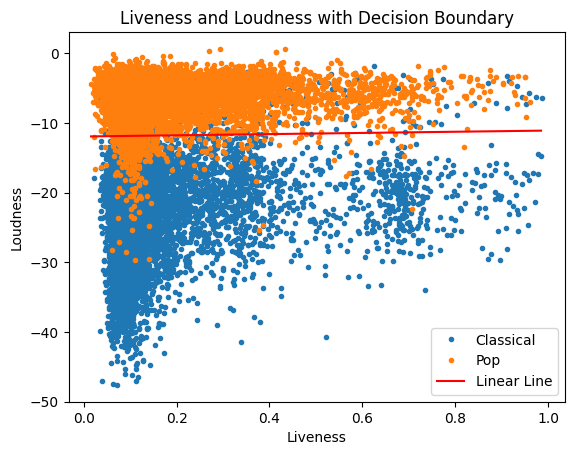

In [6]:
# 2c)
groups = dataset_with_picked_features.groupby('label')
for name, group in groups:
    label_to_genre = 'Pop' if name == 1 else 'Classical'
    plt.plot(group['liveness'], group['loudness'], marker='o', linestyle='', markersize=3,  label=label_to_genre)
    plt.legend()


# To make line go from first to last element
x1 = np.linspace(np.min(X_train[:, 0]), np.max(X_train[:, 0]))
# w1x1 + w2x2 + w0 = 0
# w1*x1 + w2*y + bias = 0
# y = (-w0 / w1) * x1 - (bias/w1)
y = (-weights[0] / weights[1]) * x1 - (bias / weights[1])

plt.plot(x1, y, color='red', label='Linear Line')

# Add labels and title
plt.xlabel('Liveness')
plt.ylabel('Loudness')
plt.title('Liveness and Loudness with Decision Boundary')
plt.legend()

# Show the plot
plt.show()

/var/folders/xc/bb9b3wdd27n8_02btpd2yfj00000gp/T/ipykernel_89454/3938742672.py:30: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(['']+['Pop', 'Classical'])
/var/folders/xc/bb9b3wdd27n8_02btpd2yfj00000gp/T/ipykernel_89454/3938742672.py:31: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(['']+['Pop', 'Classical'])


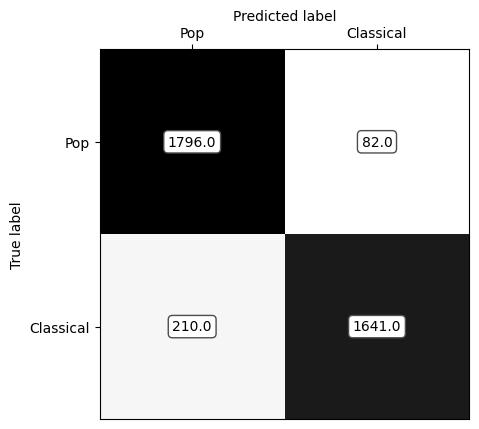

In [7]:
# 3a)
classical_predict_pop = 0
pop_predict_classical = 0
classical_predict_classical = 0
pop_predict_pop = 0

# Calculate elements in confusion matrix
for y_test_element, y_test_prediction_element in zip(y_test, y_test_prediction):
    if(y_test_element == 1 and y_test_prediction_element == 1):
        pop_predict_pop += 1
    if(y_test_element == 1 and y_test_prediction_element == 0):
        pop_predict_classical += 1
    if(y_test_element == 0 and y_test_prediction_element == 1):
        classical_predict_pop += 1
    if(y_test_element == 0 and y_test_prediction_element == 0):
        classical_predict_classical += 1


# Plotting out confusion matrix with matplotlib.
data = [[pop_predict_pop, pop_predict_classical],
         [classical_predict_pop, classical_predict_classical]]

fig, ax = plt.subplots()
ax.matshow(data, cmap='Greys', interpolation='nearest')

for (i, j), z in np.ndenumerate(data):
    ax.text(j, i, '{:0.1f}'.format(z), ha='center', va='center',
            bbox=dict(boxstyle='round', facecolor='white', edgecolor='0.3'))
    
ax.set_yticklabels(['']+['Pop', 'Classical'])
ax.set_xticklabels(['']+['Pop', 'Classical'])
ax.xaxis.set_ticks_position('top')
ax.xaxis.set_label_position('top')

plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()